# Datasets
In this notebook, we will be exploring Huggingface's dataset library. Huggingface provides a wide variety of datasets that we can easily load to train our machine learning model.

In [1]:
#| default_exp datasets

Note the `#|export` comment below. It exports the imports in the cell to the nbdev environment.

In [2]:
#|export
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

In [4]:
import logging, pickle, gzip, os, time, shutil, torch, matplotlib as mpl
from pathlib import Path

from torch import tensor, nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

## HuggingFace Datasets

In [6]:
name = "fashion_mnist"
# `load_dataset_builder` does not download dataset
# instead, it provides key information
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [7]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [8]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [9]:
# `load_dataset` is the function that downloads the dataset
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [10]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [11]:
# destructure 'image' and 'label' for convenience
x, y = ds_builder.info.features

In [12]:
img = train[0][x]
img

In [13]:
xb = train[:5][x]
yb = train[:5][y]

In [14]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [15]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [16]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [17]:
# Helper function to 'stack' indv data points into a batch
@inplace
def transformi(b): 
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [18]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [19]:
??default_collate

Signature: default_collate(batch)
Source:   
def default_collate(batch):
    r"""
        Function that takes in a batch of data and puts the elements within the batch
        into a tensor with an additional outer dimension - batch size. The exact output type can be
        a :class:`torch.Tensor`, a `Sequence` of :class:`torch.Tensor`, a
        Collection of :class:`torch.Tensor`, or left unchanged, depending on the input type.
        This is used as the default function for collation when
        `batch_size` or `batch_sampler` is defined in :class:`~torch.utils.data.DataLoader`.

        Here is the general input type (based on the type of the element within the batch) to output type mapping:

            * :class:`torch.Tensor` -> :class:`torch.Tensor` (with an added outer dimension batch size)
            * NumPy Arrays -> :class:`torch.Tensor`
            * `float` -> :class:`torch.Tensor`
            * `int` -> :class:`torch.Tensor`
            * `str` -> `str` (unchanged)
  

In [20]:
??tdsf

Type:        Dataset
String form:
Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})
Length:      60000
File:        ~/miniconda3/envs/np/lib/python3.11/site-packages/datasets/arrow_dataset.py
Source:     
class Dataset(DatasetInfoMixin, IndexableMixin, TensorflowDatasetMixin):
    """A Dataset backed by an Arrow table."""

    def __init__(
        self,
        arrow_table: Table,
        info: Optional[DatasetInfo] = None,
        split: Optional[NamedSplit] = None,
        indices_table: Optional[Table] = None,
        fingerprint: Optional[str] = None,
    ):
        info = info.copy() if info is not None else DatasetInfo()
        DatasetInfoMixin.__init__(self, info=info, split=split)
        IndexableMixin.__init__(self)

        self._data: Table = _check_table(arrow_table)
        self._indices: Optional[Table] = _check_table(indices_table) if indices_table is not None else None
        maybe_register_dataset_for_temp_dir_deletion(self)

        self._format_t

In [21]:
tdsf.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [22]:
get = itemgetter(*tdsf.features)
get

operator.itemgetter('image', 'label')

In [23]:
get(default_collate(tdsf))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0,  ..., 3, 0, 5]))

`get(default_collate(tdsf))` essentially retrieves the `x` and `y` component of our `tdsf`, then collate (stack them into tensors) them separately.

In [3]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [4]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [25]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

What the function above is doing is:
1. Given `tdsf` (the training set with x and y values), split them into `x_train` and `y_train`.
2. Stack them into the `num_samples` by other dimensions of that data.
3. Create a `Dataloader` with given `batch_size`.
4. Create an iterator for this DataLoader.

# Plotting images
We want to get good at plotting images since it helps us to visualise the data.

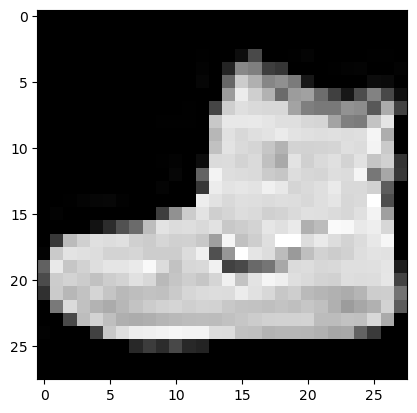

In [35]:
plt.imshow(xb[0].reshape(28,28))

`@fc.delegates` will allow user to inspect the parameters (with default values) passed from `show_image` to `plt.Axes.imshow` method. This then allows the user to better trace the code, as opposed to just seeing `**kwargs`.

In [5]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1, 2, 0)
    elif not isinstance(im.np.ndarray): im = np.array(im)

    if im.shape[-1]==1: im=im[...,0]

    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)

    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    if noframe: ax.axis('off')

    return ax

In [37]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



<Axes: >

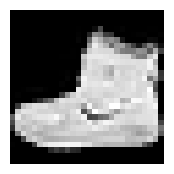

In [38]:
show_image(xb[0].reshape(28,28), figsize=(2,2))

<Axes: >

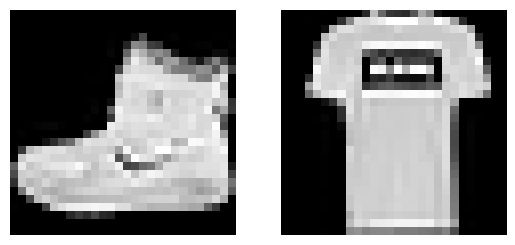

In [39]:
fig, axs = plt.subplots(1, 2)
show_image(xb[0].reshape(28,28), axs[0])
show_image(xb[1].reshape(28,28), axs[1])

In [6]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # num rows in returned axes grid
    ncols:int=1, # num cols in returned axes grid
    figsize:tuple=None, # height and width in inches of returned figure
    imsize:int=3, # size (in inches) of images that will be displayed in the returned figure
    subtitle:str=None, # title to be set to the returned fig
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if subtitle is not None: fig.subtitle(subtitle)

    if nrows*ncols==1: ax.nparray([ax])

    return fig, ax

In [41]:
from nbdev.showdoc import show_doc

In [42]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                subtitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | num rows in returned axes grid |
| ncols | int | 1 | num cols in returned axes grid |
| figsize | tuple | None | height and width in inches of returned figure |
| imsize | int | 3 | size (in inches) of images that will be displayed in the returned figure |
| subtitle | str | None | title to be set to the returned fig |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

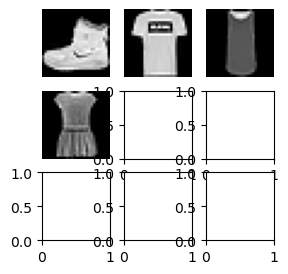

In [45]:
fig, axs = subplots(3, 3, imsize=1)
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs): show_image(img.reshape(28,28), ax)

Only 4 images are displayed because our batch size is 4.

In [46]:
xb.shape

torch.Size([4, 784])

In [7]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # number of axes
    nrows:int=None, # number of rows, defaults to `int(math.sqrt(n))`
    ncols:int=None, # number of cols, defaults to `ceil(n/rows)`
    title:str=None, # Title set to figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))

    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols):
        axs.flat[i].set_axis_off()

    if title is not None: fig.subtitle(title, weight=weight, size=size)
    return fig, axs

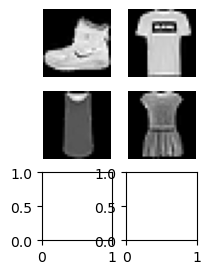

In [49]:
fig, axs = get_grid(8, nrows=3, imsize=1)
for ax, img in zip(axs.flat, imgs): show_image(img.reshape(28,28), ax)

In [8]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of cols in grid
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t)

In [60]:
yb.shape

torch.Size([4])

In [61]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*yb)(names)
' '.join(titles)

'Boot Top Top Dress'

In [62]:
??itemgetter

Init signature: itemgetter(self, /, *args, **kwargs)
Docstring:     
itemgetter(item, ...) --> itemgetter object

Return a callable object that fetches the given item(s) from its operand.
After f = itemgetter(2), the call f(r) returns r[2].
After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
Source:        
class itemgetter:
    """
    Return a callable object that fetches the given item(s) from its operand.
    After f = itemgetter(2), the call f(r) returns r[2].
    After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
    """
    __slots__ = ('_items', '_call')

    def __init__(self, item, *items):
        if not items:
            self._items = (item,)
            def func(obj):
                return obj[item]
            self._call = func
        else:
            self._items = items = (item,) + items
            def func(obj):
                return tuple(obj[i] for i in items)
            self._call = func

    def __call__(self, obj):
  

In [65]:
imgs = imgs.reshape(4, 28, 28)

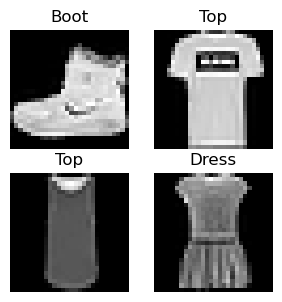

In [66]:
show_images(imgs, imsize=1.7, titles=titles)

In [9]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

# Export

In [14]:
import nbdev; nbdev.export.nb_export('05_datasets.ipynb', lib_path="miniai")